
_This supervised learning model will predict good loans versus the bad loans.  The good loans are loan_status = Fully Paid. The bad loans are the loans with a 'loan_status' = Charged Off, Late (31-120 days) and Default.

# Tuning RFC and XGB
 

In [1]:
import warnings
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
sns.set(style="darkgrid")

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

Again the baseline for this data is calculated below to be 74.83%

1    65793
0    22130
Name: good_loan_status, dtype: int64 
baseline: 0.2517
 
 1    0.748302
0    0.251698
Name: good_loan_status, dtype: float64


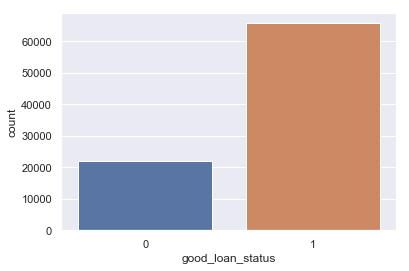

In [3]:
good = df['good_loan_status']
sns.countplot(good)
good_temp = df['good_loan_status'].value_counts()
print(good_temp,
      '\nbaseline: {:.4f}\n'.format(good_temp[0]/(good_temp[0]+good_temp[1])),
      '\n', df['good_loan_status'].value_counts(normalize=True))

In [4]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70338, 41), (70338,), (17585, 41), (17585,))

# Random Forest tuning
I am tuning the following features and I will apply adaboost to the tuned model. The model will run a 3 fold cross validation.

    - 'max_depth'
    - 'min_samples_leaf'
    - 'n_estimators'
    - 'max_features'
    - 'min_samples_split'

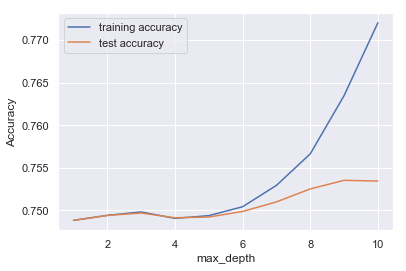

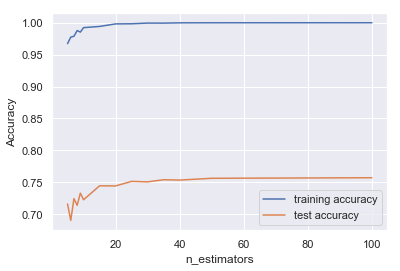

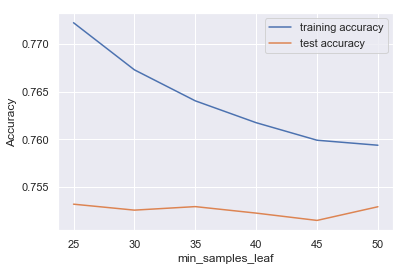

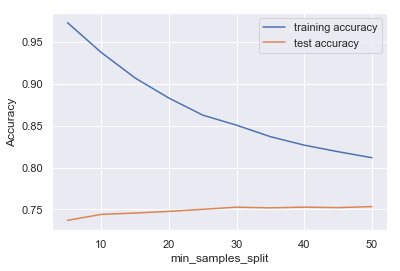

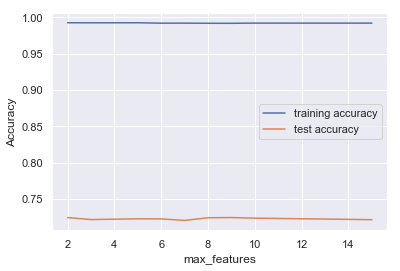

--- 941.7052 seconds --- 


In [6]:
# parameters to build the model on

start_time = time.time()

hyperparameter = ['max_depth',
                  'n_estimators',
                  'min_samples_leaf',
                  'min_samples_split',
                  'max_features']

range = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 100],
    [25, 30, 35, 40, 45, 50],
    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    [2, 3, 5, 6, 7, 8, 9, 10, 15]
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    rf = ensemble.RandomForestClassifier()

    # fit tree on training data
    rfgrid = GridSearchCV(rf, parameters,
                          cv=3,
                          scoring="accuracy")
    rfgrid.fit(X_train, y_train)
    scores = rfgrid.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___Using the parameters above to fine tune to find the best model___

In [7]:
# Create the parameter grid based on the results of random search

param_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [20, 80, 100],
    'min_samples_leaf': [50, 55,70,80],
    'min_samples_split': [60, 70, 80, 100],
    'max_features': [6, 8, 10]
}
# Create a based model
rf_tree = ensemble.RandomForestClassifier()
# Instantiate the grid search model
rfgrid_search = GridSearchCV(estimator=rf_tree,
                             param_grid=param_grid,
                             cv=3, n_jobs=-1, verbose=1)

In [8]:
# Fit the grid search to the data
start_time = time.time()
rfgrid_search.fit(X_train, y_train)

stop = timeit.default_timer()
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 88.1min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 118.9min finished


--- 7140.1268 seconds --- 


In [9]:
# printing the optimal accuracy score and hyperparameters
print('The best RFC accuracy score is {0:.4f}'.format(
    rfgrid_search.best_score_),
    'and has the parameters\n', rfgrid_search.best_params_)

The best RFC accuracy score is 0.7525 and has the parameters
 {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 60, 'n_estimators': 20}


In [10]:
# model with the best hyperparameters
rf_final = ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=8,
                                           max_features=10,
                                           min_samples_leaf=50,
                                           min_samples_split=60,
                                           n_estimators=20)

# Random Forest Results
Tuned RFC has an accuracy score of `75.25%` which is better than the baseline `74.83%` but by only `0.42%`

------ 

### Random Forest Features

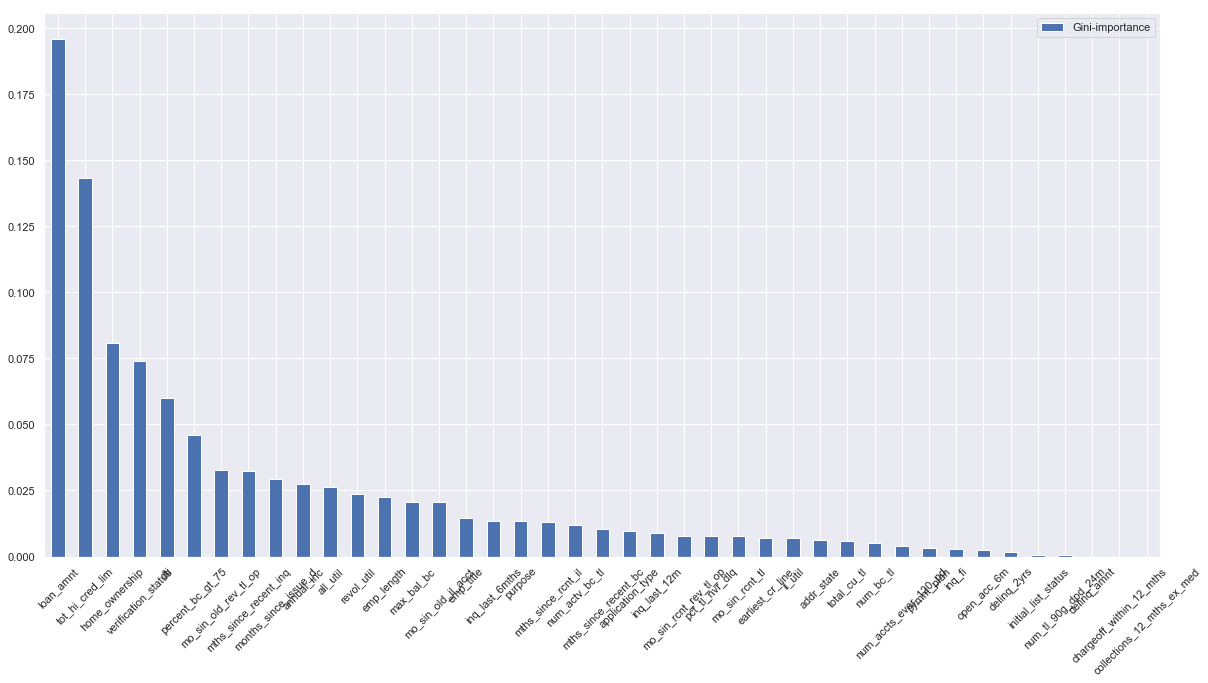

In [34]:
feats = {}  # a dict to hold feature_name: feature_importance
rf_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, rf_final.feature_importances_):
    feats[feature] = importance

importances_rf = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances_rf.sort_values(by='Gini-importance',
                        ascending=False).head(41).plot(kind='bar',
                                                       rot=45,
                                                       figsize=(20, 10))

The top 10 features to be used in unsupervised clustering

In [12]:
importances_rf.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
loan_amnt,0.198623
tot_hi_cred_lim,0.179556
verification_status,0.070099
dti,0.063228
home_ownership,0.050839
percent_bc_gt_75,0.042385
mo_sin_old_rev_tl_op,0.036358
months_since_issue_d,0.032061
mths_since_recent_inq,0.029577
revol_util,0.026031


-----

# AdaBoostClassifier tuning

In [13]:
# adaboost with the RF tree as base estimator
start_time = time.time()
estimators = np.arange(1, 20, 1)

ada_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(base_estimator=rf_final,
                             n_estimators=n_est)

    res = cross_val_score(ABC,
                          X_train,
                          y_train,
                          cv=3)

    print("\nThe average accuracy score: {0:.4f}".format(np.mean(res)), n_est)
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))


The average accuracy score: 0.7515 1

The average accuracy score: 0.7562 2

The average accuracy score: 0.7598 3

The average accuracy score: 0.7598 4

The average accuracy score: 0.7603 5

The average accuracy score: 0.7603 6

The average accuracy score: 0.7603 7

The average accuracy score: 0.7603 8

The average accuracy score: 0.7605 9

The average accuracy score: 0.7606 10

The average accuracy score: 0.7610 11

The average accuracy score: 0.7601 12

The average accuracy score: 0.7612 13

The average accuracy score: 0.7615 14

The average accuracy score: 0.7604 15

The average accuracy score: 0.7607 16

The average accuracy score: 0.7605 17

The average accuracy score: 0.7596 18

The average accuracy score: 0.7595 19
--- 1250.4266 seconds --- 


In [18]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=14)

# ADABoost Results
Tuned ADABoost with n_estimator of `14`has an accuracy score of `76.14%` which is better than the baseline `74.83%` but by only `1.31%` and `0.89%` better than Random Forest.

------ 

## ADABoost Features

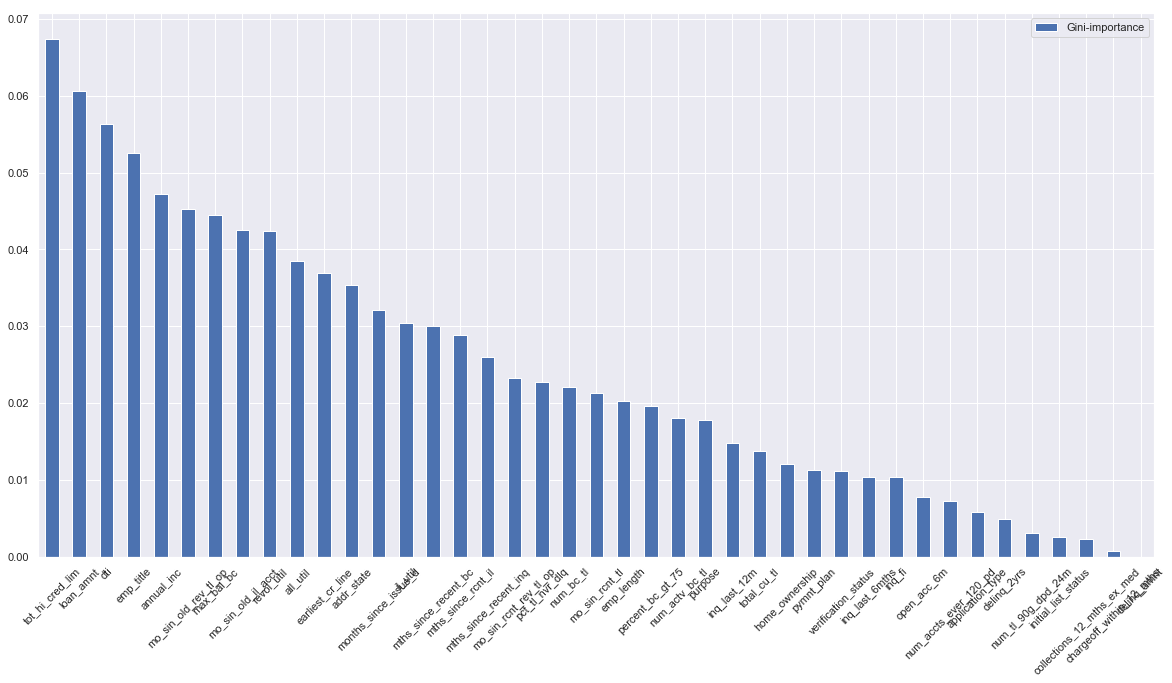

In [36]:
feats = {}  # a dict to hold feature_name: feature_importance
ada_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, ada_final.feature_importances_):
    feats[feature] = importance

ada_importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
ada_importances.sort_values(by='Gini-importance',
                            ascending=False).head(41).plot(kind='bar',
                                                           rot=45,
                                                           figsize=(20, 10))

In [22]:
ada_importances.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
loan_amnt,0.072261
tot_hi_cred_lim,0.064866
dti,0.054040
emp_title,0.051163
mo_sin_old_rev_tl_op,0.045521
annual_inc,0.044742
all_util,0.041402
max_bal_bc,0.040338
mo_sin_old_il_acct,0.040308
revol_util,0.038783


_Feature importance of the boosted Random Forest.  Past medical expenses and open accounts are big factors in getting approved for a loan._

-------------

# XGB Boost Tuning

I am tuning the following features to get the best score
    - 'max_depth'
    - 'learning_rate'
    - 'n_estimators'
    - 'subsample'
    - 'colsample_bytree'
    - 'colsample_bylevel'

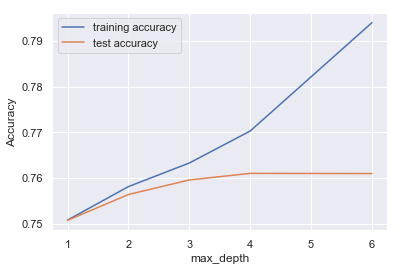

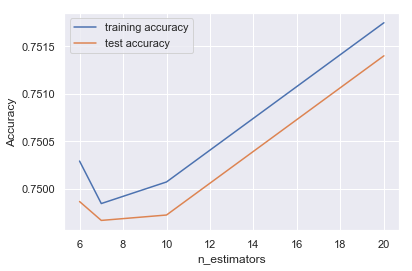

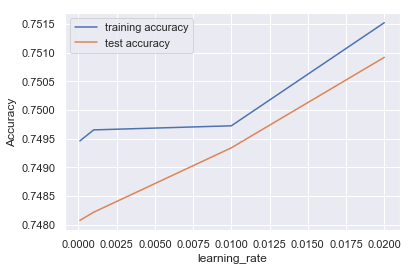

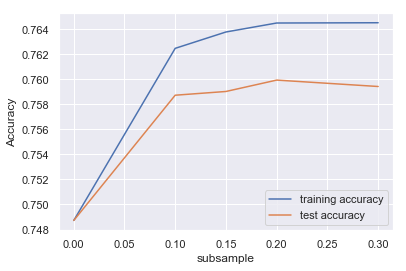

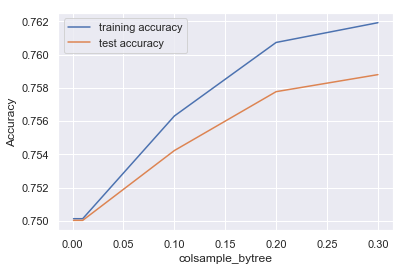

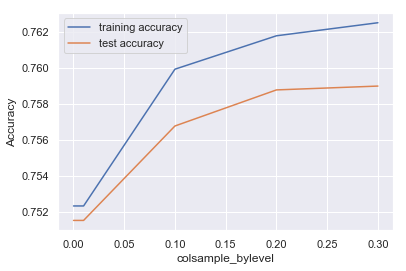

--- 631.3091 seconds --- 


In [23]:
start_time = time.time()


# parameters to build the model on
hyperparameter = ['max_depth',
                  'n_estimators',
                  'learning_rate',
                  'subsample',
                  'colsample_bytree',
                  'colsample_bylevel']

range = [
    [1, 2, 3, 4, 6],
    [6, 7, 10, 20],
    [0.0001, 0.001, 0.01, 0.02],
    [0.0001, 0.1, 0.15, 0.2, 0.3],
    [0.001, 0.01, 0.1, 0.2, 0.3],
    [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    XGB = XGBClassifier()

    # fit tree on training data
    XGB = GridSearchCV(XGB, parameters,
                       cv=3,
                       scoring="accuracy")  # you can change scoring functions right here.
    XGB.fit(X_train, y_train)
    scores = XGB.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___now let's plug in the values to get the final parameters___

In [28]:
param_grid = {
    'max_depth': [6,10,12],
    'n_estimators': [7,8,10],
    'learning_rate': [0.01, 0.0125,0.1],
    'subsample': [0.02, 0.03],
    'colsample_bytree': [0.3,0.5],
    'colsample_bylevel': [0.1,0.3, 0.5], }
# Create a based model
xgb = XGBClassifier()
# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                        cv=3, n_jobs=-1, verbose=1)

In [29]:
# Fit the grid search to the data
start_time = time.time()
xgb_grid.fit(X_train, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  8.1min finished


--- 486.3113 seconds --- 


In [30]:
# printing the optimal accuracy score and hyperparameters
print('The best XGB accuracy score is {0:.4f}'.format(
    xgb_grid.best_score_), 'with parameters\n', xgb_grid.best_params_)

The best XGB accuracy score is 0.7494 with parameters
 {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.0125, 'max_depth': 6, 'n_estimators': 8, 'subsample': 0.03}


In [35]:
xgb_param_grid = {
    'max_depth': [6],
    'n_estimators': [8],
    'learning_rate': [0.0125],
    'subsample': [0.03],
    'colsample_bytree': [0.5],
    'colsample_bylevel': [0.5]}
xgb_final = XGBClassifier()

xgb_grid_f = GridSearchCV(estimator=xgb_final, param_grid=xgb_param_grid,
                          cv=3, n_jobs=-1, verbose=1)
xgb_grid_f.fit(X_train, y_train)
print('We can get accuracy of {0:.4f}'.format(
    xgb_grid_f.best_score_), 'with parameters\n', xgb_grid_f.best_params_)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


We can get accuracy of 0.7494 with parameters
 {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.0125, 'max_depth': 6, 'n_estimators': 8, 'subsample': 0.03}
--- 2446.0692 seconds --- 


# XGB Results

The accuracy score for XGBoost: `74.94%` which is `0.11%` better than the baseline `74.83%`.

-----

## XBG Features

In [37]:
xgb.fit(X_train, y_train)
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

                        feature  importance
1                    loan_amnt          85
0              tot_hi_cred_lim          56
3                          dti          52
8         months_since_issue_d          40
11                    all_util          28
2             percent_bc_gt_75          27
10                  emp_length          27
13        mo_sin_old_rev_tl_op          25
17                  annual_inc          23
6                   max_bal_bc          21
4                   pymnt_plan          19
19                     purpose          19
15                   emp_title          18
16          mths_since_rcnt_il          18
5          verification_status          16
12       mths_since_recent_inq          15
9               inq_last_6mths          15
7               home_ownership          15
28          mo_sin_old_il_acct          14
26              num_actv_bc_tl          12
20              mo_sin_rcnt_tl          11
21                  addr_state          11
29       m

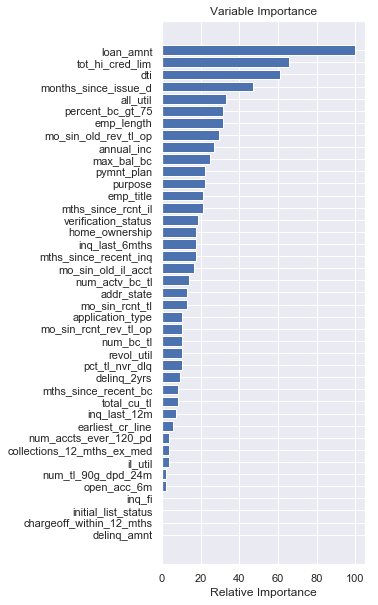

In [38]:
fig = plt.figure(figsize=(8, 10))
feature_importance = xgb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

-----

# Conclusion of Results

So ADABoost had the better score`76.14` for predicting good loans.

`1.31%` better than the baseline`(74.83%)`

`1.34%` better than XGBoost`(74.87%)`

`0.89%` better than Random Forest`(75.25%)`


76.14% of the time the ADABoost model is able to predict whether a loan is good. XGB barely beats the baseline. Now I will use the tuned values to compare the accuracy of all the models.  Looking at the features, there are more that can clearly be removed before modeling as they don't add value to the model.